## Hybrid method: Recursive feature elimination

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score

## Read Data

In [2]:
data = pd.read_csv('../UNSW_Train.csv')
data.shape

(175341, 44)

In [3]:
data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack,is_intrusion
0,0.121478,113.0,0.0,2.0,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,0,0
1,0.649902,113.0,0.0,2.0,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,0,0
2,1.623129,113.0,0.0,2.0,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,0,0
3,1.681642,113.0,3.0,2.0,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,0,0
4,0.449454,113.0,0.0,2.0,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,0,0


### Train - Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['is_intrusion', 'attack'], axis=1),
    data['is_intrusion'],
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((140272, 42), (35069, 42))

In [5]:
from sklearn.feature_selection import RFECV
import xgboost as xgb
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

clf_3 = xgb.XGBClassifier(random_state=42)
rfecv = RFECV(estimator=clf_3, step=1, cv=5, scoring='accuracy', n_jobs=-1)
rfecv.fit(X_test, y_test)


OPtimal number of features:  26


NameError: name 'x_train' is not defined

In [6]:

print('OPtimal number of features: ', rfecv.n_features_)
print('Best features: ', X_test.columns[rfecv.support_])

OPtimal number of features:  26
Best features:  Index(['dur', 'proto', 'service', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl',
       'sloss', 'dloss', 'sinpkt', 'djit', 'tcprtt', 'synack', 'smean',
       'dmean', 'trans_depth', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst'],
      dtype='object')


In [8]:
accuracy_score(y_test, rfecv.predict(X_test))

0.982662750577433

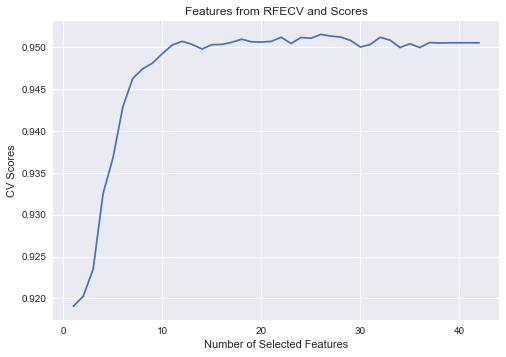

In [11]:
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import time
num_features = [i for i in range(1, len(rfecv.grid_scores_)+1)]
cv_scores = rfecv.grid_scores_
ax = sns.lineplot(x=num_features, y=cv_scores)
ax.set(xlabel = 'Number of Selected Features', ylabel='CV Scores')
plt.title('Features from RFECV and Scores');

### Remove constant and quasi-constant features

In [18]:
# to speed things up we remove constant, quasi-constand and duplicated features
quasi_constant_feat = []

# iterate over every feature
for feature in X_train.columns:

    # find the predominant value, that is the value that is shared
    # by most observations
    predominant = (X_train[feature].value_counts() / np.float64(
        len(X_train))).sort_values(ascending=False).values[0]

    # evaluate the predominant feature: do more than 99% of the observations
    # show 1 value?
    if predominant > 0.998:
        
        # if yes, add the variable to the list
        quasi_constant_feat.append(feature)

X_train.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_test.drop(labels=quasi_constant_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((140272, 42), (35069, 42))

### Remove duplicated features

In [19]:
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10
20
30
40


1

In [20]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((140272, 41), (35069, 41))

### Build ML model with all features

In [22]:
# build initial model using all the features
model_full = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)
model_full.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_full.predict_proba(X_test)[:, 1]
roc_full = roc_auc_score(y_test, y_pred_test)

print('Test ROC AUC=%f' % (roc_full))

Test ROC AUC=0.984772


### Rank features by importance

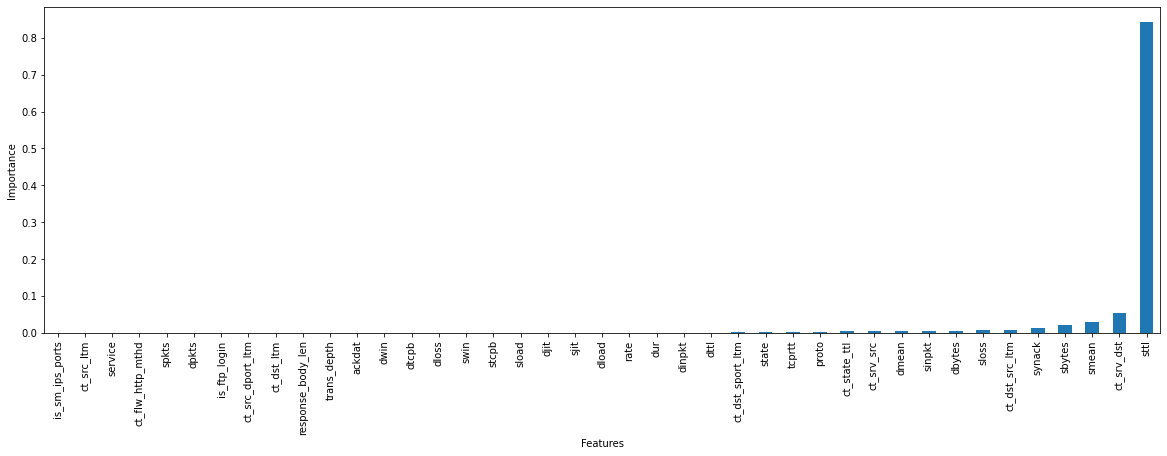

In [23]:
# get feature name and importance
features = pd.Series(model_full.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=True, inplace=True)

# plot
features.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [24]:
# make list of ordered features
features = list(features.index)
features

['is_sm_ips_ports',
 'ct_src_ltm',
 'service',
 'ct_flw_http_mthd',
 'spkts',
 'dpkts',
 'is_ftp_login',
 'ct_src_dport_ltm',
 'ct_dst_ltm',
 'response_body_len',
 'trans_depth',
 'ackdat',
 'dwin',
 'dtcpb',
 'dloss',
 'swin',
 'stcpb',
 'sload',
 'djit',
 'sjit',
 'dload',
 'rate',
 'dur',
 'dinpkt',
 'dttl',
 'ct_dst_sport_ltm',
 'state',
 'tcprtt',
 'proto',
 'ct_state_ttl',
 'ct_srv_src',
 'dmean',
 'sinpkt',
 'dbytes',
 'sloss',
 'ct_dst_src_ltm',
 'synack',
 'sbytes',
 'smean',
 'ct_srv_dst',
 'sttl']

### Select features

In [25]:
# first we arbitrarily set the drop in roc-auc
# if the drop is below this threshold, the feature will be removed
tol = 0.0005

print('doing recursive feature elimination')

# we initialise a list where we will collect the features we should remove
features_to_remove = []

# set a counter to know where the loop is
count = 1

# now we loop over all the features, in order of importance:
# remember that features is this list are ordered by importance
for feature in features:
    
    print()
    print('testing feature: ', feature, count, ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

    # fit model with all variables, minus the feature to be evaluated
    # and also minus all features that were deemed to be removed
    
    # note that features_to_remove will be empty in the first rounds
    # but will have features as the loop proceeds
    model_int.fit(
        X_train.drop(features_to_remove + [feature], axis=1), y_train)

    # make a prediction using the test set
    y_pred_test = model_int.predict_proba(
        X_test.drop(features_to_remove + [feature], axis=1))[:, 1]

    # calculate the new roc-auc
    roc_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((roc_int)))

    # print the original roc-auc with all the features
    print('Full dataset ROC AUC={}'.format((roc_full)))

    # determine the drop in the roc-auc
    diff_roc = roc_full - roc_int

    # compare the drop in roc-auc with the tolerance
    # we set previously
    if diff_roc >= tol:
        print('Drop in ROC AUC={}'.format(diff_roc))
        print('keep: ', feature)
        print
    else:
        print('Drop in ROC AUC={}'.format(diff_roc))
        print('remove: ', feature)
        print
        # if the drop in the roc is small and we remove the
        # feature, we need to set the new roc to the one based on
        # the remaining features
        roc_full = roc_int
        
        # and append the feature to remove to the collecting list
        features_to_remove.append(feature)

# now the loop is finished, we evaluated all the features
print('Done!')
print('total features to remove: ', len(features_to_remove), )

# determine the features to keep (those we won't remove)
features_to_keep = [x for x in features if x not in features_to_remove]
print('total features to keep: ', len(features_to_keep))

# Sit back and relax, this will take a while!

doing recursive feature elimination

testing feature:  is_sm_ips_ports 1  out of  41
New Test ROC AUC=0.984772157283715
Full dataset ROC AUC=0.9847721572837149
Drop in ROC AUC=-1.1102230246251565e-16
remove:  is_sm_ips_ports

testing feature:  ct_src_ltm 2  out of  41
New Test ROC AUC=0.984772157283715
Full dataset ROC AUC=0.984772157283715
Drop in ROC AUC=0.0
remove:  ct_src_ltm

testing feature:  service 3  out of  41
New Test ROC AUC=0.984772157283715
Full dataset ROC AUC=0.984772157283715
Drop in ROC AUC=0.0
remove:  service

testing feature:  ct_flw_http_mthd 4  out of  41
New Test ROC AUC=0.984772157283715
Full dataset ROC AUC=0.984772157283715
Drop in ROC AUC=0.0
remove:  ct_flw_http_mthd

testing feature:  spkts 5  out of  41
New Test ROC AUC=0.984772157283715
Full dataset ROC AUC=0.984772157283715
Drop in ROC AUC=0.0
remove:  spkts

testing feature:  dpkts 6  out of  41
New Test ROC AUC=0.984772157283715
Full dataset ROC AUC=0.984772157283715
Drop in ROC AUC=0.0
remove:  dpkts

In [26]:
features_to_remove

['is_sm_ips_ports',
 'ct_src_ltm',
 'service',
 'ct_flw_http_mthd',
 'spkts',
 'dpkts',
 'is_ftp_login',
 'ct_src_dport_ltm',
 'ct_dst_ltm',
 'response_body_len',
 'trans_depth',
 'ackdat',
 'dwin',
 'dtcpb',
 'dloss',
 'swin',
 'stcpb',
 'sload',
 'djit',
 'sjit',
 'dload',
 'rate',
 'dur',
 'dinpkt',
 'dttl',
 'ct_dst_sport_ltm',
 'state',
 'tcprtt',
 'proto',
 'ct_state_ttl',
 'ct_srv_src',
 'dmean',
 'sinpkt',
 'dbytes',
 'sloss',
 'ct_dst_src_ltm']

In [27]:
# for comparison, building a model with the selected features only

model_final = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

# fit the model with the selected features
model_final.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = model_final.predict_proba(X_test[features_to_keep])[:, 1]

# calculate roc-auc
roc_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (roc_final))

Test selected features ROC AUC=0.983401


The Gradient Boosting model built with 5 features shows a similar performance than the one built the full dataset (you need to scroll up to find this value, we calculated a few cells ago).

In [28]:
X_train = X_train[features_to_keep]
X_test = X_test[features_to_keep]

In [29]:
X_train.shape, X_test.shape

((140272, 5), (35069, 5))

## Standardize Data





In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

## Classifiers




In [31]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

## Metrics Evaluation




In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, f1_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score

### Logistic Regression





In [33]:
%%time
clf_LR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=25).fit(X_train, y_train)

CPU times: user 70.5 ms, sys: 209 ms, total: 279 ms
Wall time: 1.58 s


In [34]:
pred_y_test = clf_LR.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_test))

f1 = f1_score(y_test, pred_y_test)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_test)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.6793179161082438
F1 Score: 0.8090402771174354
FPR: 1.0
TPR: 1.0


### Naive Bayes





In [35]:
%%time
clf_NB = GaussianNB(var_smoothing=1e-08).fit(X_train, y_train)

CPU times: user 25.5 ms, sys: 10.5 ms, total: 36 ms
Wall time: 34.1 ms


In [36]:
pred_y_testNB = clf_NB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testNB))

f1 = f1_score(y_test, pred_y_testNB)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testNB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.6793179161082438
F1 Score: 0.8090402771174354
FPR: 1.0
TPR: 1.0


### Random Forest




In [37]:
%%time
clf_RF = RandomForestClassifier(random_state=0,max_depth=100,n_estimators=1000).fit(X_train, y_train)

CPU times: user 1min 15s, sys: 558 ms, total: 1min 16s
Wall time: 1min 16s


In [38]:
pred_y_testRF = clf_RF.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testRF))

f1 = f1_score(y_test, pred_y_testRF, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testRF)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.436767515469503
F1 Score: 0.43755931111025387
FPR: 0.32518228703539037
TPR: 0.32439239390504976


### KNN



In [39]:
%%time
clf_KNN = KNeighborsClassifier(algorithm='ball_tree',leaf_size=1,n_neighbors=5,weights='uniform').fit(X_train, y_train)

CPU times: user 6.07 s, sys: 35.3 ms, total: 6.1 s
Wall time: 6.07 s


In [40]:
pred_y_testKNN = clf_KNN.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, pred_y_testKNN))

f1 = f1_score(y_test, pred_y_testKNN)
print('f1:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testKNN)
print('fpr:', fpr[1])
print('tpr:', tpr[1])

accuracy_score: 0.6793179161082438
f1: 0.8090402771174354
fpr: 1.0
tpr: 1.0


### CatBoost





In [41]:
%%time
clf_CB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04).fit(X_train, y_train)

0:	learn: 0.6614186	total: 64ms	remaining: 3.13s
1:	learn: 0.6321516	total: 72.2ms	remaining: 1.73s
2:	learn: 0.6051877	total: 80.8ms	remaining: 1.27s
3:	learn: 0.5796181	total: 88.9ms	remaining: 1.02s
4:	learn: 0.5562272	total: 97.3ms	remaining: 876ms
5:	learn: 0.5343287	total: 106ms	remaining: 777ms
6:	learn: 0.5136401	total: 115ms	remaining: 709ms
7:	learn: 0.4942646	total: 124ms	remaining: 653ms
8:	learn: 0.4759765	total: 133ms	remaining: 604ms
9:	learn: 0.4589651	total: 141ms	remaining: 565ms
10:	learn: 0.4429617	total: 150ms	remaining: 532ms
11:	learn: 0.4278223	total: 158ms	remaining: 502ms
12:	learn: 0.4137152	total: 169ms	remaining: 481ms
13:	learn: 0.4002077	total: 178ms	remaining: 458ms
14:	learn: 0.3875321	total: 187ms	remaining: 436ms
15:	learn: 0.3755443	total: 195ms	remaining: 414ms
16:	learn: 0.3641080	total: 203ms	remaining: 394ms
17:	learn: 0.3532678	total: 211ms	remaining: 375ms
18:	learn: 0.3431392	total: 220ms	remaining: 359ms
19:	learn: 0.3334697	total: 228ms	rema

In [42]:
pred_y_testCB = clf_CB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testCB))

f1 = f1_score(y_test, pred_y_testCB, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testCB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.6795175225983062
F1 Score: 0.550059853343659
FPR: 0.9993775564645208
TPR: 1.0


## Model Evaluation




In [43]:
import pandas as pd, numpy as np
test_df = pd.read_csv("../UNSW_Test.csv")
test_df.shape

(175341, 44)

In [44]:
# Create feature matrix X and target vextor y
y_eval = test_df['is_intrusion']
X_eval = test_df.drop(columns=['is_intrusion'])

In [45]:
X_eval = X_eval[features_to_keep]

In [46]:
X_eval.shape

(175341, 5)

### Model Evaluation - Logistic Regression




In [47]:
modelLR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=25)
modelLR.fit(X_train, y_train)

LogisticRegression(C=25, n_jobs=-1, random_state=42)

In [48]:
# Predict on the new unseen test data
y_evalpredLR = modelLR.predict(X_eval)
y_predLR = modelLR.predict(X_test)

In [49]:
train_scoreLR = modelLR.score(X_train, y_train)
test_scoreLR = modelLR.score(X_test, y_test)
print("Training accuracy is ", train_scoreLR)
print("Testing accuracy is ", test_scoreLR)

Training accuracy is  0.8494781567240789
Testing accuracy is  0.6793179161082438


In [50]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreLR)
print('F1 Score:',f1_score(y_test, y_predLR))
print('Precision Score:',precision_score(y_test, y_predLR))
print('Recall Score:', recall_score(y_test, y_predLR))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predLR))

Performance measures for test:
--------
Accuracy: 0.6793179161082438
F1 Score: 0.8090402771174354
Precision Score: 0.6793179161082438
Recall Score: 1.0
Confusion Matrix:
 [[    0 11246]
 [    0 23823]]


### Cross validation - Logistic Regression




In [51]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.84874 (+/- 0.12902)
F1 Score: 0.88927 (+/- 0.07576)
Precision: 0.92053 (+/- 0.20319)
Recall: 0.87278 (+/- 0.12381)


### Model Evaluation - Naive Bayes




In [52]:
modelNB = GaussianNB(var_smoothing=1e-08)
modelNB.fit(X_train, y_train)

GaussianNB(var_smoothing=1e-08)

In [53]:
# Predict on the new unseen test data
y_evalpredNB = modelNB.predict(X_eval)
y_predNB = modelNB.predict(X_test)

In [54]:
train_scoreNB = modelNB.score(X_train, y_train)
test_scoreNB = modelNB.score(X_test, y_test)
print("Training accuracy is ", train_scoreNB)
print("Testing accuracy is ", test_scoreNB)

Training accuracy is  0.560503878179537
Testing accuracy is  0.6793179161082438


In [55]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreNB)
print('F1 Score:',f1_score(y_test, y_predNB))
print('Precision Score:',precision_score(y_test, y_predNB))
print('Recall Score:', recall_score(y_test, y_predNB))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predNB))


Performance measures for test:
--------
Accuracy: 0.6793179161082438
F1 Score: 0.8090402771174354
Precision Score: 0.6793179161082438
Recall Score: 1.0
Confusion Matrix:
 [[    0 11246]
 [    0 23823]]


### Cross validation - Naive Bayes




In [56]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.50404 (+/- 0.34064)
F1 Score: 0.39226 (+/- 0.60292)
Precision: 0.90819 (+/- 0.18533)
Recall: 0.34822 (+/- 0.71842)


### Model Evaluation - Random Forest





In [57]:
modelRF = RandomForestClassifier(random_state=0,max_depth=100,n_estimators=1000)
modelRF.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, n_estimators=1000, random_state=0)

In [58]:
# Predict on the new unseen test data
y_evalpredRF = modelRF.predict(X_eval)
y_predRF = modelRF.predict(X_test)

In [59]:
train_scoreRF = modelRF.score(X_train, y_train)
test_scoreRF = modelRF.score(X_test, y_test)
print("Training accuracy is ", train_scoreRF)
print("Testing accuracy is ", test_scoreRF)

Training accuracy is  0.99254305919927
Testing accuracy is  0.436767515469503


In [60]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreRF)
print('F1 Score:', f1_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Precision Score:', precision_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predRF))

Performance measures for test:
--------
Accuracy: 0.436767515469503
F1 Score: 0.43755931111025387
Precision Score: 0.5638680592523927
Recall Score: 0.436767515469503
Confusion Matrix:
 [[ 7589  3657]
 [16095  7728]]


### Cross validation - Random Forest





In [61]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.92823 (+/- 0.11507)
F1 Score: 0.95006 (+/- 0.07343)
Precision: 0.94248 (+/- 0.16112)
Recall: 0.96340 (+/- 0.05291)


### Model Evaluation - KNN





In [62]:
modelKNN = KNeighborsClassifier(algorithm='ball_tree',leaf_size=1,n_neighbors=5,weights='uniform')
modelKNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=1)

In [63]:
# Predict on the new unseen test data
y_evalpredKNN = modelKNN.predict(X_eval)
y_predKNN = modelKNN.predict(X_test)

In [64]:
train_scoreKNN = modelKNN.score(X_train, y_train)
test_scoreKNN = modelKNN.score(X_test, y_test)
print("Training accuracy is ", train_scoreKNN)
print("Testing accuracy is ", test_scoreKNN)

Training accuracy is  0.9545597125584578
Testing accuracy is  0.6793179161082438


In [65]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreKNN)
print('F1 Score:', f1_score(y_test, y_predKNN))
print('Precision Score:', precision_score(y_test, y_predKNN))
print('Recall Score:', recall_score(y_test, y_predKNN))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predKNN))

Performance measures for test:
--------
Accuracy: 0.6793179161082438
F1 Score: 0.8090402771174354
Precision Score: 0.6793179161082438
Recall Score: 1.0
Confusion Matrix:
 [[    0 11246]
 [    0 23823]]


### Cross validation - KNN




In [66]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.92598 (+/- 0.10733)
F1 Score: 0.94809 (+/- 0.06861)
Precision: 0.94281 (+/- 0.15517)
Recall: 0.95876 (+/- 0.05254)


### Model Evaluation - CatBoost





In [67]:
modelCB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04)
modelCB.fit(X_train, y_train)

0:	learn: 0.6614186	total: 8.27ms	remaining: 405ms
1:	learn: 0.6321516	total: 16.7ms	remaining: 400ms
2:	learn: 0.6051877	total: 25.3ms	remaining: 396ms
3:	learn: 0.5796181	total: 33.4ms	remaining: 384ms
4:	learn: 0.5562272	total: 41ms	remaining: 369ms
5:	learn: 0.5343287	total: 48.9ms	remaining: 359ms
6:	learn: 0.5136401	total: 58.5ms	remaining: 359ms
7:	learn: 0.4942646	total: 66.8ms	remaining: 351ms
8:	learn: 0.4759765	total: 74.9ms	remaining: 341ms
9:	learn: 0.4589651	total: 82.9ms	remaining: 331ms
10:	learn: 0.4429617	total: 91ms	remaining: 322ms
11:	learn: 0.4278223	total: 98.6ms	remaining: 312ms
12:	learn: 0.4137152	total: 106ms	remaining: 301ms
13:	learn: 0.4002077	total: 114ms	remaining: 293ms
14:	learn: 0.3875321	total: 122ms	remaining: 284ms
15:	learn: 0.3755443	total: 129ms	remaining: 275ms
16:	learn: 0.3641080	total: 138ms	remaining: 268ms
17:	learn: 0.3532678	total: 146ms	remaining: 260ms
18:	learn: 0.3431392	total: 155ms	remaining: 252ms
19:	learn: 0.3334697	total: 163ms

In [68]:
# Predict on the new unseen test data
y_evalpredCB = modelCB.predict(X_eval)
y_predCB = modelCB.predict(X_test)

In [69]:
train_scoreCB = modelCB.score(X_train, y_train)
test_scoreCB = modelCB.score(X_test, y_test)
print("Training accuracy is ", train_scoreCB)
print("Testing accuracy is ", test_scoreCB)

Training accuracy is  0.9409718261663055
Testing accuracy is  0.6795175225983062


In [70]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreCB)
print('F1 Score:',f1_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Precision Score:',precision_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predCB))

Performance measures for test:
--------
Accuracy: 0.6795175225983062
F1 Score: 0.550059853343659
Precision Score: 0.7822470463995052
Recall Score: 0.6795175225983062
Confusion Matrix:
 [[    7 11239]
 [    0 23823]]


### Cross validation - CatBoost





In [71]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='accuracy')
f = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='f1')
precision = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='precision')
recall = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='recall')

0:	learn: 0.6615932	total: 8.8ms	remaining: 431ms
1:	learn: 0.6325742	total: 17.5ms	remaining: 420ms
2:	learn: 0.6054317	total: 26.2ms	remaining: 410ms
3:	learn: 0.5801527	total: 35.1ms	remaining: 404ms
4:	learn: 0.5569267	total: 43.7ms	remaining: 393ms
5:	learn: 0.5349270	total: 52.9ms	remaining: 388ms
6:	learn: 0.5146963	total: 62.4ms	remaining: 383ms
7:	learn: 0.4952828	total: 72.3ms	remaining: 380ms
8:	learn: 0.4770654	total: 83.2ms	remaining: 379ms
9:	learn: 0.4600815	total: 95.4ms	remaining: 382ms
10:	learn: 0.4440843	total: 104ms	remaining: 370ms
11:	learn: 0.4290024	total: 113ms	remaining: 359ms
12:	learn: 0.4148083	total: 122ms	remaining: 348ms
13:	learn: 0.4014496	total: 132ms	remaining: 338ms
14:	learn: 0.3888108	total: 141ms	remaining: 330ms
15:	learn: 0.3768452	total: 150ms	remaining: 319ms
16:	learn: 0.3655081	total: 159ms	remaining: 308ms
17:	learn: 0.3547061	total: 167ms	remaining: 298ms
18:	learn: 0.3445679	total: 178ms	remaining: 290ms
19:	learn: 0.3348819	total: 186m

13:	learn: 0.4030500	total: 132ms	remaining: 340ms
14:	learn: 0.3904525	total: 142ms	remaining: 332ms
15:	learn: 0.3786348	total: 152ms	remaining: 324ms
16:	learn: 0.3673705	total: 164ms	remaining: 318ms
17:	learn: 0.3566312	total: 173ms	remaining: 308ms
18:	learn: 0.3466041	total: 182ms	remaining: 298ms
19:	learn: 0.3369430	total: 193ms	remaining: 289ms
20:	learn: 0.3277840	total: 204ms	remaining: 281ms
21:	learn: 0.3190903	total: 213ms	remaining: 271ms
22:	learn: 0.3109547	total: 221ms	remaining: 260ms
23:	learn: 0.3031335	total: 231ms	remaining: 250ms
24:	learn: 0.2958057	total: 240ms	remaining: 240ms
25:	learn: 0.2886220	total: 251ms	remaining: 231ms
26:	learn: 0.2818187	total: 260ms	remaining: 222ms
27:	learn: 0.2752288	total: 270ms	remaining: 212ms
28:	learn: 0.2691123	total: 282ms	remaining: 204ms
29:	learn: 0.2632393	total: 293ms	remaining: 195ms
30:	learn: 0.2578813	total: 302ms	remaining: 185ms
31:	learn: 0.2526216	total: 311ms	remaining: 175ms
32:	learn: 0.2475167	total: 320

29:	learn: 0.2661712	total: 282ms	remaining: 188ms
30:	learn: 0.2606556	total: 292ms	remaining: 179ms
31:	learn: 0.2554219	total: 302ms	remaining: 170ms
32:	learn: 0.2504293	total: 311ms	remaining: 160ms
33:	learn: 0.2456448	total: 321ms	remaining: 151ms
34:	learn: 0.2412429	total: 330ms	remaining: 141ms
35:	learn: 0.2369208	total: 339ms	remaining: 132ms
36:	learn: 0.2326225	total: 349ms	remaining: 123ms
37:	learn: 0.2286176	total: 358ms	remaining: 113ms
38:	learn: 0.2250096	total: 367ms	remaining: 103ms
39:	learn: 0.2214065	total: 376ms	remaining: 94ms
40:	learn: 0.2179492	total: 385ms	remaining: 84.5ms
41:	learn: 0.2145228	total: 394ms	remaining: 75.1ms
42:	learn: 0.2113220	total: 403ms	remaining: 65.6ms
43:	learn: 0.2083693	total: 412ms	remaining: 56.2ms
44:	learn: 0.2055298	total: 421ms	remaining: 46.7ms
45:	learn: 0.2027961	total: 430ms	remaining: 37.4ms
46:	learn: 0.2003562	total: 439ms	remaining: 28ms
47:	learn: 0.1978868	total: 448ms	remaining: 18.7ms
48:	learn: 0.1955491	total

44:	learn: 0.1899218	total: 409ms	remaining: 45.5ms
45:	learn: 0.1871676	total: 419ms	remaining: 36.5ms
46:	learn: 0.1845869	total: 430ms	remaining: 27.5ms
47:	learn: 0.1819633	total: 440ms	remaining: 18.3ms
48:	learn: 0.1794753	total: 450ms	remaining: 9.18ms
49:	learn: 0.1770253	total: 459ms	remaining: 0us
0:	learn: 0.6615932	total: 8.35ms	remaining: 409ms
1:	learn: 0.6325742	total: 16.8ms	remaining: 404ms
2:	learn: 0.6054317	total: 25.3ms	remaining: 397ms
3:	learn: 0.5801527	total: 34.1ms	remaining: 392ms
4:	learn: 0.5569267	total: 42.8ms	remaining: 385ms
5:	learn: 0.5349270	total: 51.5ms	remaining: 378ms
6:	learn: 0.5146963	total: 59.8ms	remaining: 367ms
7:	learn: 0.4952828	total: 69ms	remaining: 362ms
8:	learn: 0.4770654	total: 78.3ms	remaining: 357ms
9:	learn: 0.4600815	total: 87.7ms	remaining: 351ms
10:	learn: 0.4440843	total: 96.9ms	remaining: 344ms
11:	learn: 0.4290024	total: 106ms	remaining: 337ms
12:	learn: 0.4148083	total: 117ms	remaining: 334ms
13:	learn: 0.4014496	total: 1

14:	learn: 0.3904525	total: 135ms	remaining: 314ms
15:	learn: 0.3786348	total: 144ms	remaining: 306ms
16:	learn: 0.3673705	total: 154ms	remaining: 299ms
17:	learn: 0.3566312	total: 163ms	remaining: 290ms
18:	learn: 0.3466041	total: 172ms	remaining: 281ms
19:	learn: 0.3369430	total: 181ms	remaining: 271ms
20:	learn: 0.3277840	total: 190ms	remaining: 262ms
21:	learn: 0.3190903	total: 199ms	remaining: 253ms
22:	learn: 0.3109547	total: 208ms	remaining: 244ms
23:	learn: 0.3031335	total: 217ms	remaining: 236ms
24:	learn: 0.2958057	total: 227ms	remaining: 227ms
25:	learn: 0.2886220	total: 236ms	remaining: 218ms
26:	learn: 0.2818187	total: 245ms	remaining: 208ms
27:	learn: 0.2752288	total: 253ms	remaining: 199ms
28:	learn: 0.2691123	total: 262ms	remaining: 190ms
29:	learn: 0.2632393	total: 272ms	remaining: 181ms
30:	learn: 0.2578813	total: 281ms	remaining: 172ms
31:	learn: 0.2526216	total: 289ms	remaining: 163ms
32:	learn: 0.2475167	total: 299ms	remaining: 154ms
33:	learn: 0.2427565	total: 309

43:	learn: 0.2083693	total: 412ms	remaining: 56.1ms
44:	learn: 0.2055298	total: 421ms	remaining: 46.8ms
45:	learn: 0.2027961	total: 431ms	remaining: 37.5ms
46:	learn: 0.2003562	total: 441ms	remaining: 28.1ms
47:	learn: 0.1978868	total: 449ms	remaining: 18.7ms
48:	learn: 0.1955491	total: 458ms	remaining: 9.35ms
49:	learn: 0.1930432	total: 467ms	remaining: 0us
0:	learn: 0.6603716	total: 10.7ms	remaining: 526ms
1:	learn: 0.6301951	total: 19.8ms	remaining: 476ms
2:	learn: 0.6022749	total: 28.8ms	remaining: 452ms
3:	learn: 0.5761653	total: 37.4ms	remaining: 430ms
4:	learn: 0.5518127	total: 46ms	remaining: 414ms
5:	learn: 0.5291357	total: 54.9ms	remaining: 403ms
6:	learn: 0.5078476	total: 63.3ms	remaining: 389ms
7:	learn: 0.4877844	total: 72.2ms	remaining: 379ms
8:	learn: 0.4688539	total: 81.8ms	remaining: 373ms
9:	learn: 0.4512904	total: 91.1ms	remaining: 364ms
10:	learn: 0.4347344	total: 100ms	remaining: 355ms
11:	learn: 0.4191088	total: 110ms	remaining: 347ms
12:	learn: 0.4045111	total: 1

12:	learn: 0.4148083	total: 119ms	remaining: 338ms
13:	learn: 0.4014496	total: 129ms	remaining: 331ms
14:	learn: 0.3888108	total: 139ms	remaining: 325ms
15:	learn: 0.3768452	total: 149ms	remaining: 317ms
16:	learn: 0.3655081	total: 159ms	remaining: 309ms
17:	learn: 0.3547061	total: 168ms	remaining: 299ms
18:	learn: 0.3445679	total: 178ms	remaining: 291ms
19:	learn: 0.3348819	total: 187ms	remaining: 281ms
20:	learn: 0.3256632	total: 197ms	remaining: 271ms
21:	learn: 0.3168993	total: 206ms	remaining: 262ms
22:	learn: 0.3085955	total: 215ms	remaining: 252ms
23:	learn: 0.3007188	total: 226ms	remaining: 244ms
24:	learn: 0.2934454	total: 235ms	remaining: 235ms
25:	learn: 0.2861751	total: 244ms	remaining: 226ms
26:	learn: 0.2793218	total: 254ms	remaining: 216ms
27:	learn: 0.2726842	total: 263ms	remaining: 207ms
28:	learn: 0.2664866	total: 272ms	remaining: 197ms
29:	learn: 0.2605636	total: 281ms	remaining: 188ms
30:	learn: 0.2549709	total: 290ms	remaining: 178ms
31:	learn: 0.2496671	total: 299

36:	learn: 0.2294833	total: 343ms	remaining: 120ms
37:	learn: 0.2253878	total: 353ms	remaining: 111ms
38:	learn: 0.2215325	total: 362ms	remaining: 102ms
39:	learn: 0.2178800	total: 371ms	remaining: 92.9ms
40:	learn: 0.2142592	total: 381ms	remaining: 83.6ms
41:	learn: 0.2107874	total: 390ms	remaining: 74.3ms
42:	learn: 0.2076454	total: 399ms	remaining: 65ms
43:	learn: 0.2044555	total: 408ms	remaining: 55.7ms
44:	learn: 0.2016339	total: 417ms	remaining: 46.4ms
45:	learn: 0.1987572	total: 426ms	remaining: 37.1ms
46:	learn: 0.1960252	total: 436ms	remaining: 27.8ms
47:	learn: 0.1936427	total: 445ms	remaining: 18.5ms
48:	learn: 0.1912474	total: 454ms	remaining: 9.26ms
49:	learn: 0.1889298	total: 463ms	remaining: 0us
0:	learn: 0.6618286	total: 8.85ms	remaining: 434ms
1:	learn: 0.6330240	total: 18.2ms	remaining: 436ms
2:	learn: 0.6061232	total: 27.5ms	remaining: 430ms
3:	learn: 0.5810544	total: 36.1ms	remaining: 416ms
4:	learn: 0.5578666	total: 44.7ms	remaining: 402ms
5:	learn: 0.5362481	total

6:	learn: 0.5078476	total: 66.4ms	remaining: 408ms
7:	learn: 0.4877844	total: 76.1ms	remaining: 400ms
8:	learn: 0.4688539	total: 85.2ms	remaining: 388ms
9:	learn: 0.4512904	total: 95.9ms	remaining: 384ms
10:	learn: 0.4347344	total: 105ms	remaining: 371ms
11:	learn: 0.4191088	total: 114ms	remaining: 361ms
12:	learn: 0.4045111	total: 123ms	remaining: 351ms
13:	learn: 0.3906610	total: 132ms	remaining: 340ms
14:	learn: 0.3775748	total: 141ms	remaining: 329ms
15:	learn: 0.3652587	total: 150ms	remaining: 318ms
16:	learn: 0.3538816	total: 159ms	remaining: 308ms
17:	learn: 0.3427517	total: 168ms	remaining: 298ms
18:	learn: 0.3323250	total: 177ms	remaining: 288ms
19:	learn: 0.3222160	total: 185ms	remaining: 278ms
20:	learn: 0.3126064	total: 194ms	remaining: 268ms
21:	learn: 0.3036055	total: 203ms	remaining: 258ms
22:	learn: 0.2950792	total: 212ms	remaining: 249ms
23:	learn: 0.2869082	total: 222ms	remaining: 240ms
24:	learn: 0.2791204	total: 231ms	remaining: 231ms
25:	learn: 0.2718092	total: 240

22:	learn: 0.3085955	total: 211ms	remaining: 248ms
23:	learn: 0.3007188	total: 221ms	remaining: 239ms
24:	learn: 0.2934454	total: 231ms	remaining: 231ms
25:	learn: 0.2861751	total: 240ms	remaining: 222ms
26:	learn: 0.2793218	total: 250ms	remaining: 213ms
27:	learn: 0.2726842	total: 259ms	remaining: 203ms
28:	learn: 0.2664866	total: 268ms	remaining: 194ms
29:	learn: 0.2605636	total: 279ms	remaining: 186ms
30:	learn: 0.2549709	total: 289ms	remaining: 177ms
31:	learn: 0.2496671	total: 298ms	remaining: 168ms
32:	learn: 0.2446587	total: 307ms	remaining: 158ms
33:	learn: 0.2398615	total: 316ms	remaining: 149ms
34:	learn: 0.2352123	total: 325ms	remaining: 139ms
35:	learn: 0.2307304	total: 334ms	remaining: 130ms
36:	learn: 0.2263170	total: 344ms	remaining: 121ms
37:	learn: 0.2222503	total: 353ms	remaining: 111ms
38:	learn: 0.2183974	total: 364ms	remaining: 103ms
39:	learn: 0.2147191	total: 373ms	remaining: 93.3ms
40:	learn: 0.2110605	total: 382ms	remaining: 83.9ms
41:	learn: 0.2075623	total: 3

0:	learn: 0.6618286	total: 8.69ms	remaining: 426ms
1:	learn: 0.6330240	total: 17.3ms	remaining: 415ms
2:	learn: 0.6061232	total: 26.1ms	remaining: 410ms
3:	learn: 0.5810544	total: 35ms	remaining: 403ms
4:	learn: 0.5578666	total: 43.5ms	remaining: 391ms
5:	learn: 0.5362481	total: 52.4ms	remaining: 384ms
6:	learn: 0.5160126	total: 61.2ms	remaining: 376ms
7:	learn: 0.4968022	total: 70.3ms	remaining: 369ms
8:	learn: 0.4786961	total: 79.2ms	remaining: 361ms
9:	learn: 0.4618471	total: 88.2ms	remaining: 353ms
10:	learn: 0.4460249	total: 97.5ms	remaining: 346ms
11:	learn: 0.4310227	total: 107ms	remaining: 338ms
12:	learn: 0.4169223	total: 116ms	remaining: 331ms
13:	learn: 0.4035893	total: 125ms	remaining: 322ms
14:	learn: 0.3909909	total: 135ms	remaining: 314ms
15:	learn: 0.3790420	total: 144ms	remaining: 305ms
16:	learn: 0.3680933	total: 153ms	remaining: 297ms
17:	learn: 0.3571983	total: 162ms	remaining: 288ms
18:	learn: 0.3471810	total: 171ms	remaining: 279ms
19:	learn: 0.3375411	total: 180m

27:	learn: 0.2579746	total: 260ms	remaining: 204ms
28:	learn: 0.2515967	total: 270ms	remaining: 195ms
29:	learn: 0.2454691	total: 280ms	remaining: 186ms
30:	learn: 0.2398212	total: 289ms	remaining: 177ms
31:	learn: 0.2344085	total: 298ms	remaining: 168ms
32:	learn: 0.2291836	total: 307ms	remaining: 158ms
33:	learn: 0.2240680	total: 316ms	remaining: 149ms
34:	learn: 0.2193020	total: 325ms	remaining: 139ms
35:	learn: 0.2147229	total: 335ms	remaining: 130ms
36:	learn: 0.2103945	total: 345ms	remaining: 121ms
37:	learn: 0.2062205	total: 354ms	remaining: 112ms
38:	learn: 0.2022315	total: 363ms	remaining: 102ms
39:	learn: 0.1984572	total: 373ms	remaining: 93.2ms
40:	learn: 0.1947943	total: 383ms	remaining: 84.1ms
41:	learn: 0.1914126	total: 394ms	remaining: 75ms
42:	learn: 0.1881776	total: 403ms	remaining: 65.6ms
43:	learn: 0.1850258	total: 412ms	remaining: 56.1ms
44:	learn: 0.1819563	total: 421ms	remaining: 46.7ms
45:	learn: 0.1791660	total: 430ms	remaining: 37.4ms
46:	learn: 0.1763634	total

In [72]:
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.92348 (+/- 0.17320)
F1 Score: 0.94959 (+/- 0.10661)
Precision: 0.92642 (+/- 0.20368)
Recall: 0.98181 (+/- 0.03103)
